# **CIS 5450 Group Project: Predicting Airbnb Price**

**Problem to Solve:**
As a team of data scientists, our primary objective is to develop a robust predictive model that empowers Airbnb investors to optimize their pricing strategies effectively. By accurately forecasting revenue potential, we can provide valuable insights into monthly cash flow, enabling investors to make informed decisions and maximize profitability.

**Team Members:**
*   Ivan Paul Dingle (ivanpaul)
*   Peter Liu (yuhsul1)
*   Selasi Doe (selasi)
*   Tingting Duan(duant)

# **Imports/Setup**

Run the following cells to set up the notebook.

In [ ]:
# import packages
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
import plotly.express as px
import json
from collections import Counter
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import re
import datetime as dt
from wordcloud import WordCloud

#**Part 1: Data Loading and Preprocessing**

##**1.1 Data Loading**

We used one CSV file from Kaggle for this project, `Airbnb_Open_Data.csv`, which was stored into a dataframe `df_airbnb`. The dataset contains Airbnb properties located all throughout NYC. While the dataset contained features pertaining to location, neighbourhood, room types, house rules, and various credentials, we did not have information in regard to amenities, number of rooms/beds, or square footage.  We were most interested in the `price` column, a string variable indiciating a property's market price, to build a prediction model on future Airbnb properties. We also used an additional GeoJSON file from Kaggle to help identify NYC zipcodes for location coordinates.

In [ ]:
%%capture
!apt update
!pip install kaggle
!pip install uszipcode

In [ ]:
# Run this cell to mount Google drive
from google.colab import drive
drive.mount('/content/drive')
# Create the kaggle directory
!mkdir ~/.kaggle

Mounted at /content/drive


In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download dataset
!!kaggle datasets download -d arianazmoudeh/airbnbopendata

['Downloading airbnbopendata.zip to /content',
 '',
 '  0% 0.00/10.5M [00:00<?, ?B/s]',
 '100% 10.5M/10.5M [00:00<00:00, 107MB/s]',
 '',
 '100% 10.5M/10.5M [00:00<00:00, 107MB/s]']

In [ ]:
# Unzip folder in Colab content folder
!unzip /content/airbnbopendata.zip

Archive:  /content/airbnbopendata.zip
  inflating: Airbnb_Open_Data.csv    


In [ ]:
'''TOGGLE HERE IF ALREADY RAN THROUGH 2.3.1 Geolocation'''
# df_airbnb = pd.read_csv('/content/drive/MyDrive/airbnb_clean.csv')

'TOGGLE HERE IF ALREADY RAN THROUGH 2.3.1 Geolocation'

In [ ]:
'''Don't run this cell if running the cell above'''
# Read the csv file and save it to a dataframe called "df_airbnb"
df_airbnb = pd.read_csv('Airbnb_Open_Data.csv')

<ipython-input-8-6a9567fd3f23>:3: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_airbnb = pd.read_csv('Airbnb_Open_Data.csv')


In [ ]:
# Geojson file for using plotly to define zipcode region
!!kaggle datasets download -d ashioyajotham/nyc-geojson-file

['Downloading nyc-geojson-file.zip to /content',
 '',
 '  0% 0.00/173k [00:00<?, ?B/s]',
 '',
 '100% 173k/173k [00:00<00:00, 61.3MB/s]']

In [ ]:
!unzip /content/nyc-geojson-file.zip

Archive:  /content/nyc-geojson-file.zip
  inflating: nyc-zip-code-tabulation-areas-polygons.geojson  


## **1.2 Data Preview**

We individually started to explore our dataset `df_airbnb` as a preview to form our own understandings on how to approach preprocessing in preparation for Exploratory Data Analysis (EDA).

In [ ]:
# Peek at the first three rows to understand the values in each column
df_airbnb.head(2)

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,country code,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,US,False,strict,Private room,2020.0,$966,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,US,False,moderate,Entire home/apt,2007.0,$142,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN


In [ ]:
# check shape
df_airbnb.shape

(102599, 26)

In [ ]:
# check basic stat
df_airbnb.describe()

,id,host id,lat,long,Construction year,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
count,1.025990e+05,1.025990e+05,102591.000000,102591.000000,102385.000000,102190.000000,102416.000000,86720.000000,102273.000000,102280.000000,102151.000000
mean,2.914623e+07,4.925411e+10,40.728094,-73.949644,2012.487464,8.135845,27.483743,1.374022,3.279106,7.936605,141.133254
std,1.625751e+07,2.853900e+10,0.055857,0.049521,5.765556,30.553781,49.508954,1.746621,1.284657,32.218780,135.435024
min,1.001254e+06,1.236005e+08,40.499790,-74.249840,2003.000000,-1223.000000,0.000000,0.010000,1.000000,1.000000,-10.000000
25%,1.508581e+07,2.458333e+10,40.688740,-73.982580,2007.000000,2.000000,1.000000,0.220000,2.000000,1.000000,3.000000
50%,2.913660e+07,4.911774e+10,40.722290,-73.954440,2012.000000,3.000000,7.000000,0.740000,3.000000,1.000000,96.000000
75%,4.320120e+07,7.399650e+10,40.762760,-73.932350,2017.000000,5.000000,30.000000,2.000000,4.000000,2.000000,269.000000
max,5.736742e+07,9.876313e+10,40.916970,-73.705220,2022.000000,5645.000000,1024.000000,90.000000,5.000000,332.000000,3677.000000


In [ ]:
# check the datatypes in `df_airbnb`
df_airbnb.dtypes

id                                  int64
NAME                               object
host id                             int64
host_identity_verified             object
host name                          object
neighbourhood group                object
neighbourhood                      object
lat                               float64
long                              float64
country                            object
country code                       object
instant_bookable                   object
cancellation_policy                object
room type                          object
Construction year                 float64
price                              object
service fee                        object
minimum nights                    float64
number of reviews                 float64
last review                        object
reviews per month                 float64
review rate number                float64
calculated host listings count    float64
availability 365                  

## **1.3 Data Cleaning**

#### **1.3.1 Standardize Column Names**

For column names, we used standardized snake case to ensure consistency, which would aid in EDA and building models throughout the course of the project.

In [ ]:
# standardize column names
df_airbnb.columns = (df_airbnb.columns
                      .str.replace(' ', '_', regex=True)
                      .str.lower()
                    )
df_airbnb.columns

Index(['id', 'name', 'host_id', 'host_identity_verified', 'host_name',
       'neighbourhood_group', 'neighbourhood', 'lat', 'long', 'country',
       'country_code', 'instant_bookable', 'cancellation_policy', 'room_type',
       'construction_year', 'price', 'service_fee', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'review_rate_number', 'calculated_host_listings_count',
       'availability_365', 'house_rules', 'license'],
      dtype='object')

#### **1.3.2 Handle Duplicates**

We quanitified our number of duplicates in order to make a decision on how to clean our data.

In [ ]:
# find out how many duplicates we have
print(int(len(df_airbnb)-len(df_airbnb.drop_duplicates())))

541


In [ ]:
# find out the % of dup of total records
int(len(df_airbnb)-len(df_airbnb.drop_duplicates()))/len(df_airbnb)*100

0.5272955876762931

In [ ]:
# manually check some duplicates
ids = df_airbnb["id"]
df_airbnb[ids.isin(ids[ids.duplicated()])].sort_values("id")[:2]

,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,country,country_code,instant_bookable,cancellation_policy,room_type,construction_year,price,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,house_rules,license
9098,6026161,Upper East Side 2 bedroom- close to Hospitals-,65193709566,verified,Juliana,Manhattan,Upper East Side,40.76222,-73.9603,United States,US,False,moderate,Entire home/apt,2008.0,$105,$21,30.0,2.0,6/8/2019,0.21,3.0,34.0,157.0,NaN,NaN
102474,6026161,Upper East Side 2 bedroom- close to Hospitals-,65193709566,verified,Juliana,Manhattan,Upper East Side,40.76222,-73.9603,United States,US,False,moderate,Entire home/apt,2008.0,$105,$21,30.0,2.0,6/8/2019,0.21,3.0,34.0,157.0,NaN,NaN


##### **Decision to Handle Duplicated Values**
- Upon checking, the duplicate values were all true duplicates across the entire row, not duplicates in one or two columns (e.g., not the same listing but with different prices). The number of duplicates account for about 0.5% of the entire dataset. Therefore, we collectively decided to drop all duplicates from `df_airbnb`.

In [ ]:
df_airbnb = df_airbnb.drop_duplicates()

#### **1.3.3 Handle Null**

We then quantified the number of null values in our dataset and discussed how to handle our data.

In [ ]:
# Find number of rows with null values
for col in df_airbnb.columns:
  print(f"{int(int(df_airbnb[col].isnull().sum())/len(df_airbnb[col])*100)}% of total rows; number of rows with null values in {col} is {int(df_airbnb[col].isnull().sum())}")

0% of total rows; number of rows with null values in id is 0
0% of total rows; number of rows with null values in name is 250
0% of total rows; number of rows with null values in host_id is 0
0% of total rows; number of rows with null values in host_identity_verified is 289
0% of total rows; number of rows with null values in host_name is 404
0% of total rows; number of rows with null values in neighbourhood_group is 29
0% of total rows; number of rows with null values in neighbourhood is 16
0% of total rows; number of rows with null values in lat is 8
0% of total rows; number of rows with null values in long is 8
0% of total rows; number of rows with null values in country is 532
0% of total rows; number of rows with null values in country_code is 131
0% of total rows; number of rows with null values in instant_bookable is 105
0% of total rows; number of rows with null values in cancellation_policy is 76
0% of total rows; number of rows with null values in room_type is 0
0% of total r

##### **Decision to Handle Null Values**
- Since the `license` column was 99% null, we decided it was safe to drop the entire column.
- If `last_review` and `reviews_per_month` are null, it was likely no one had reviewed it yet. Our strategy here was to fill `reviews_per_month` with 0 and `last_review` with the oldest date in this column.
- The `house_rules` column was 50% null. Because Airbnb has their own standard house rule policy for guests, not every property manager chose to add additional specified rules for their property.  We decided to use a place holder "no rule" for all the null values.
- The remaining columns, whose percentage of null values within our dataset were close to 0%, were dropped.

In [ ]:
# Drop the "license" column because 99% rows are null
df_airbnb.drop(columns=["license"], inplace=True)

In [ ]:
# Fill "reviews_per_month" with 0 and "last_review" with the oldest date when null
df_airbnb["reviews_per_month"].fillna(0, inplace=True)

# Convert "last_review" column to datetime format
df_airbnb["last_review"] = pd.to_datetime(df_airbnb["last_review"])
df_airbnb["last_review"].fillna(df_airbnb["last_review"].min(), inplace=True)

# Insert "no rule" placeholder in the "house_rules" column for null values
df_airbnb["house_rules"].fillna("no rule", inplace=True)

# Drop rows where the remaining columns has null
df_airbnb.dropna(how='any', inplace=True)

In [ ]:
# Check null values again after processing
for col in df_airbnb.columns:
  print(f"{int(int(df_airbnb[col].isnull().sum())/len(df_airbnb[col])*100)}% of total rows; number of rows with null values in {col} is {int(df_airbnb[col].isnull().sum())}")

0% of total rows; number of rows with null values in id is 0
0% of total rows; number of rows with null values in name is 0
0% of total rows; number of rows with null values in host_id is 0
0% of total rows; number of rows with null values in host_identity_verified is 0
0% of total rows; number of rows with null values in host_name is 0
0% of total rows; number of rows with null values in neighbourhood_group is 0
0% of total rows; number of rows with null values in neighbourhood is 0
0% of total rows; number of rows with null values in lat is 0
0% of total rows; number of rows with null values in long is 0
0% of total rows; number of rows with null values in country is 0
0% of total rows; number of rows with null values in country_code is 0
0% of total rows; number of rows with null values in instant_bookable is 0
0% of total rows; number of rows with null values in cancellation_policy is 0
0% of total rows; number of rows with null values in room_type is 0
0% of total rows; number of 

In [ ]:
# Check shape of the DataFrame after handling null values
df_airbnb.shape

(98509, 25)

### **We kept 96% of the original records within `df_airbnb` after null processing.**


# **Part 2: Exploratory Data Analysis (EDA)**

#### **2.1 Understanding Data**

After collectively cleaning the data, we approached individual EDA before collaborating our findings.  Although we previewed the understanding of our dataset in our preprocessing section, we believed it was good practice to further explore and understand our clean data.  

In [ ]:
# Display the columns in df_airbnb
df_airbnb.columns

Index(['id', 'name', 'host_id', 'host_identity_verified', 'host_name',
       'neighbourhood_group', 'neighbourhood', 'lat', 'long', 'country',
       'country_code', 'instant_bookable', 'cancellation_policy', 'room_type',
       'construction_year', 'price', 'service_fee', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'review_rate_number', 'calculated_host_listings_count',
       'availability_365', 'house_rules'],
      dtype='object')

In [ ]:
# Display the datatypes in df_airbnb
datatypes = df_airbnb.dtypes
datatypes

id                                         int64
name                                      object
host_id                                    int64
host_identity_verified                    object
host_name                                 object
neighbourhood_group                       object
neighbourhood                             object
lat                                      float64
long                                     float64
country                                   object
country_code                              object
instant_bookable                          object
cancellation_policy                       object
room_type                                 object
construction_year                        float64
price                                     object
service_fee                               object
minimum_nights                           float64
number_of_reviews                        float64
last_review                       datetime64[ns]
reviews_per_month   

In [ ]:
# Display the descriptive statistics of `df_reservations`
descriptive_statistics = df_airbnb.describe()
descriptive_statistics

,id,host_id,lat,long,construction_year,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365
count,9.850900e+04,9.850900e+04,98509.000000,98509.000000,98509.000000,98509.000000,98509.000000,98509,98509.000000,98509.000000,98509.000000,98509.000000
mean,2.927555e+07,4.925024e+10,40.728036,-73.949629,2012.488138,8.046402,27.341644,2018-05-18 06:02:48.179557120,1.166535,3.278665,7.973241,140.883168
min,1.001254e+06,1.236005e+08,40.499790,-74.249840,2003.000000,-1223.000000,0.000000,2012-07-11 00:00:00,0.000000,1.000000,1.000000,-10.000000
25%,1.517556e+07,2.455589e+10,40.688720,-73.982570,2008.000000,2.000000,1.000000,2017-08-03 00:00:00,0.090000,2.000000,1.000000,3.000000
50%,2.932383e+07,4.911063e+10,40.722250,-73.954440,2012.000000,3.000000,7.000000,2019-05-22 00:00:00,0.480000,3.000000,1.000000,96.000000
75%,4.333016e+07,7.398748e+10,40.762740,-73.932270,2017.000000,5.000000,30.000000,2019-07-01 00:00:00,1.720000,4.000000,2.000000,268.000000
max,5.735803e+07,9.876313e+10,40.916970,-73.705220,2022.000000,5645.000000,1024.000000,2022-05-21 00:00:00,90.000000,5.000000,332.000000,3677.000000
std,1.622021e+07,2.854665e+10,0.055831,0.049545,5.761132,28.434029,49.216253,NaN,1.685965,1.285089,32.453375,135.397230


#### **2.2 Processing and Applying Domain Knowledge**

Upon inspecting our clean data, which exclusively contained Airbnb properties in NYC, we deemed 'country' and 'country_code' as redundant information and removed both columns.  This decision helps reduce unnecessary computational costs, which is particularly beneficial in the context of Big Data.

In [ ]:
# Drop 'country' and 'country_code' columns as all records are in the US (no value of keeping these 2 features)
df_airbnb.drop(columns=['country', 'country_code'], inplace=True)

On the topic of location, the geographical coordinates of each property were represented by 'lat' (latitude) and 'long' (longitude). Given that these columns contain precise location data, we opted to maintain their datatype as floats. This decision ensures the accuracy and integrity of the geographic information, which is crucial for any spatial analysis or mapping tasks that may follow in our data processing workflow.

We next observed that 'id' was a raw integer value. Recognizing 'id' as a basic identifier for properties, we converted it, as well as 'host_id', to string values. We also confirmed that 'name', 'host_name', 'neighbourhood_group', 'neighbourhood', and 'house_rules' retained their string format, as these columns contain textual information.

In [ ]:
# Convert specified columns to string data type
str_columns = ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'house_rules']
df_airbnb[str_columns] = df_airbnb[str_columns].astype(str)

From our descriptive statistics, we noted that 'construction_year' was a float value and 'last_review' was stored as datetime64[ns]. We made the decision to standardize these data formats:

- We converted 'construction_year' to a datetime format

- We updated 'last_review' to datetime format and extracted the date

In [ ]:
# Convert 'construction_year' to datetime format
df_airbnb['construction_year'] = pd.to_datetime(df_airbnb['construction_year'], format='%Y').dt.year

# Convert 'last_review' to datetime format and extract date
df_airbnb['last_review'] = pd.to_datetime(df_airbnb['last_review']).dt.date

In order to streamline our dataset and ensure data consistency, we converted several columns to integer datatype. These columns—'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', and 'availability_365'—were specifically chosen because their values represent discrete quantities that are more logically handled as integers. This conversion was implemented using the astype(int) function, which efficiently casts the selected columns of our DataFrame to integer datatype, thereby enhancing data handling and computation efficiency.

In [ ]:
# Convert specified columns to integer
int_columns = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number',\
               'calculated_host_listings_count', 'availability_365']
df_airbnb[int_columns] = df_airbnb[int_columns].astype(int)

In our dataset, the 'price' and 'service_fee' columns were formatted as strings containing monetary values, which included dollar signs and commas. To facilitate numerical analysis, it was necessary to convert these columns into integers. We achieved this by first removing the dollar signs and commas from each string using the str.replace() method. Following the removal of these characters, we used the pd.to_numeric() function to convert the cleaned strings into numerical data. This transformation allows for more straightforward and efficient computations involving these monetary values in our subsequent data analysis steps.

In [ ]:
# Convert 'price' and 'service_fee' string to int by removing $ and ,
df_airbnb['price'] = pd.to_numeric(df_airbnb['price'].str.replace('$', '').str.replace(',', ''))
df_airbnb['service_fee'] = pd.to_numeric(df_airbnb['service_fee'].str.replace('$', '').str.replace(',', ''))

We encoded 'instant_bookable', host_identity_verified', and 'last review' for easier data processing, especially when building our models.

In [ ]:
# Encode 'instant_bookable' column
df_airbnb['instant_bookable'] = df_airbnb['instant_bookable'].map({False: 0, True: 1})

# Encode 'host_identity_verified' column
df_airbnb['host_identity_verified'] = df_airbnb['host_identity_verified'].map({'unconfirmed': 0, 'verified': 1})

# Encode last review
df_airbnb['last_review'] = df_airbnb['last_review'].apply(lambda x: 0 if x <= dt.date(2021, 5, 21) else 1)

In [ ]:
# Inspect results after processing each column
df_airbnb.head(2)

,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,instant_bookable,cancellation_policy,room_type,construction_year,price,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,house_rules
0,1001254,Clean & quiet apt home by the park,80014485718,0,Madaline,Brooklyn,Kensington,40.64749,-73.97237,0,strict,Private room,2020,966,193,10,9,1,0,4,6,286,Clean up and treat the home the way you'd like...
1,1002102,Skylit Midtown Castle,52335172823,1,Jenna,Manhattan,Midtown,40.75362,-73.98377,0,moderate,Entire home/apt,2007,142,28,30,45,1,0,4,2,228,Pet friendly but please confirm with me if the...


---------------------------------------------

## **2.3 Visualizations**

### **2.3.1 Geolocation**

To enrich our dataset and increase the precision of our analysis, we incorporated zip code information, which was initially absent, by utilizing geolocation data. We created a function named get_zipcode, which employs the uszipcode search method to derive zip codes from the latitude and longitude coordinates of each property.



In [ ]:
# import searchEngine from uszipcode and create a searchEngine object.
from uszipcode import SearchEngine
search = SearchEngine()

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Download /root/.uszipcode/simple_db.sqlite from https://github.com/MacHu-GWU/uszipcode-project/releases/download/1.0.1.db/simple_db.sqlite ...
  1.00 MB downloaded ...
  2.00 MB downloaded ...
  3.00 MB downloaded ...
  4.00 MB downloaded ...
  5.00 MB downloaded ...
  6.00 MB downloaded ...
  7.00 MB downloaded ...
  8.00 MB downloaded ...
  9.00 MB downloaded ...
  10.00 MB downloaded ...
  11.00 MB downloaded ...
  Complete!


This function was systematically applied to each row of our DataFrame using the apply method, effectively adding a new 'zipcode' column.

In [ ]:
#zipcode search function for apply lambda function
def get_zipcode(lat, long):
    result = search.by_coordinates(lat = lat, lng = long, returns = 1)
    return result[0].zipcode

#add zipcode column with apply function on each row
df_airbnb['zipcode'] = df_airbnb.apply(lambda x: get_zipcode(x.lat,x.long), axis=1)

Given that the application of get_zipcode extended data processing times to over 30 minutes, we opted to save our enhanced dataset as airbnb_clean.csv. This allows us to preserve our progress and facilitates continued analysis without the need to repeat the zip code extraction process in future sessions.

In [ ]:
# Since getting the zipcode may take around 30 mins to run, we may want to save the csv file to reuse in the future.

df_airbnb.to_csv('/content/drive/My Drive/airbnb_clean.csv', index=False)

In [ ]:
unique_zipcodes_count = df_airbnb['zipcode'].nunique()
unique_zipcodes_count

189

To further refine our analysis and enhance our visual representations, we aggregated the data by zip code. This step involved creating a new DataFrame, df_zip_graph, where we calculated several statistics per zip code, including average price, maximum price, property count, average review rate, and average number of reviews per month. This grouping allowed us to examine trends and outliers at a more localized level.

In [ ]:
# Then we could create an aggregated dataframe that groups by zipcode to make our visualizations

df_zip_graph = df_airbnb.groupby("zipcode", as_index=False).agg(
    average_price=("price", "mean"),
    max_price = ("price", "max"),
    property_count = ("id", "count"),
    average_review = ("review_rate_number", "mean"),
    average_number_reviews_per_month = ("reviews_per_month", "mean")
)

# Look at the statistics of our data after grouping with zipcode
df_zip_graph.describe()

,zipcode,average_price,max_price,property_count,average_review,average_number_reviews_per_month
count,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,10801.767196,617.387773,1151.132275,521.211640,3.293828,1.050060
std,666.629103,69.851869,155.664835,806.353321,0.288603,0.665650
min,7020.000000,102.000000,102.000000,1.000000,2.000000,0.000000
25%,10305.000000,605.010870,1180.000000,67.000000,3.227011,0.676556
50%,11109.000000,626.367769,1196.000000,169.000000,3.302083,0.925532
75%,11361.000000,646.481818,1199.000000,651.000000,3.398601,1.329710
max,11694.000000,823.641026,1200.000000,6645.000000,5.000000,5.066667


We opened our GeoJSON file containing the geographic information of NYC zip codes, which we used to create a map with Plotly. This map visualizes the property count by zip code, using color gradients to indicate density. This geographic plotting not only provides a visual summary of property distribution but also enhances our ability to communicate these findings effectively.

In [ ]:
# Now we can open up the gejoson file and use it for our plotly graph.
# First graph is property count based on zipcode

with open('/content/nyc-zip-code-tabulation-areas-polygons.geojson') as response:
    nyjson = json.load(response)
fig = px.choropleth(df_zip_graph,
                    geojson=nyjson,
                    locations='zipcode',
                    color='property_count',
                    color_continuous_scale="Viridis",
                    featureidkey="properties.postalCode",
                    range_color=(1,5000),
                    scope="usa",
                    labels={'Total Porperties':'property_count'}
                          )
fig.update_geos(fitbounds="locations")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

Not surprisingly, most of the properties are concentrated in downtown Manhattan and Brooklyn Area.

We next observed average reviews by zipcode.

In [ ]:
# Now we look at average review group by zipcode
fig = px.choropleth(df_zip_graph,
                    geojson=nyjson,
                    locations='zipcode',
                    color='average_review',
                    color_continuous_scale="Viridis",
                    featureidkey="properties.postalCode",
                    range_color=(0,5),
                    scope="usa",
                          )
fig.update_geos(fitbounds="locations")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

If just looking at the average review, it's understandable that every zip has similar average. Satisification of the customer doesn't really depends on the neighborhood/ location, but rather the service they receive. This supports the need for additional descriptors for each property that include amenities and number of bedrooms.

In [ ]:
# Now review the average price for the rental property based on zipcode
fig = px.choropleth(df_zip_graph,
                    geojson=nyjson,
                    locations='zipcode',
                    color='average_price',
                    color_continuous_scale="Viridis",
                    featureidkey="properties.postalCode",
                    range_color=(df_zip_graph["average_price"].min(),df_zip_graph["average_price"].max()),
                    scope="usa",
                          )
fig.update_geos(fitbounds="locations")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

***Interesting Finding***: Originally was expecting Manhattan or Brooklyn to have higher average price since it's closer to the metro area. However, this graph did not consider the fact that metro area usually has smaller units (apartment/condo) while locations further away from metro area may have house/ townhouse, which has more space to potentially result in lower price/sqft.  There was a fair even distribution of prices all throughout the city.

In [ ]:
# finally we look at the number of review per month based on zipcode
fig = px.choropleth(df_zip_graph,
                    geojson=nyjson,
                    locations='zipcode',
                    color='average_number_reviews_per_month',
                    color_continuous_scale="Viridis",
                    featureidkey="properties.postalCode",
                    range_color=(df_zip_graph["average_number_reviews_per_month"].min(),df_zip_graph["average_number_reviews_per_month"].max()),
                    scope="usa",
                          )
fig.update_geos(fitbounds="locations")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

***Interesting Finding***: Using average review per month, we can treat this information as turnover rate for guest. The location with highest number of average review is right next to La Guardia Airport, and the second highest one is right next to JFK international airport. It may be worth to consider rental properties in these area, as there are higher turnover rate.

### **2.3.2 Natural Language Processing (NLP)**

Intrigued by the potential applications of NLP and the notable absence of explicit property descriptions (ex. photo images, amenities, and room counts), we decided to harness NLP techniques to extract useful data from the 'house_rules' column. Our aim was to transform unstructured text into structured data that could reveal insights about the properties listed, specifically hoping to highlight amenities and additional descriptors that influence prices.

We started with parsing 'house_rules' for common words that pertain to the property.  


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

# Function to clean and split text
def process_text(text):
    # Remove the phrase 'no rule' from text
    text = re.sub(r'\bno rule\b', '', text, flags=re.IGNORECASE)

    # Tokenize text and ensure separation of numbers and texts like '30min' into '30' and 'min'
    tokens = nltk.word_tokenize(text.lower())

    # Extend the separation of alphanumeric compounds like '30min'
    words = []
    for token in tokens:

        # Separate alphanumeric tokens into numbers and text
        separated = re.findall(r'[0-9]+|[a-z]+', token)
        words.extend(separated)

    # Define a custom list of additional words to keep
    additional_keep = ['min']

    # Load stopwords set only once and use it globally
    stop_words = set(stopwords.words('english'))

    # Remove stopwords, except for the words in 'additional_keep'
    words = [word for word in words if word not in stop_words or word in additional_keep]
    return words


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Combine all house rules into one text and process it
all_text = ' '.join(df_airbnb['house_rules'])
words = process_text(all_text)
word_counts = Counter(words)

# Print the top x most common words in 'house_rules'
x = 30
most_common_words = word_counts.most_common(x)

We created a word cloud to identify any strong/more frequent words stated in the specified house rules.

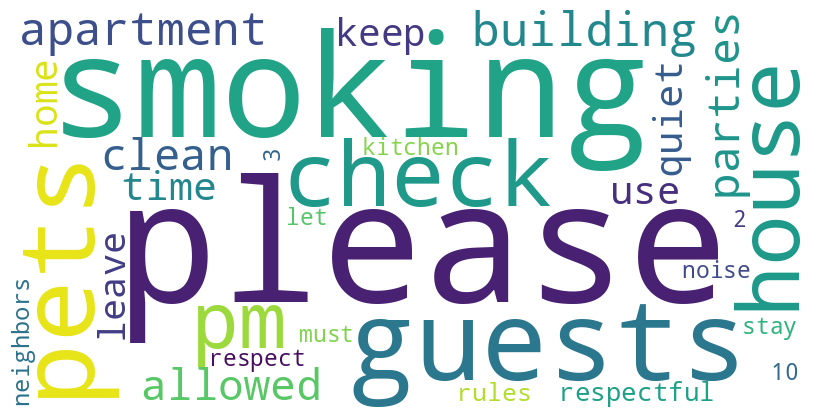

In [ ]:
# Convert list of tuples to dictionary for word cloud visual
word_freq = dict(most_common_words)

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400,
                      background_color ='white',
                      max_words=30).generate_from_frequencies(word_freq)

# Plot the WordCloud image
plt.figure(figsize = (8, 6), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

Most properties who have additional specific house rules say 'Please'--a nontrivial finding.  Many mention no smoking. Other popular words are 'pm', 'quiet' 'noise', 'parties', which probably discourage rowdy guests and/or signals a shared accomodation within their house rule.  These were all very generic words to preserve the cleanliness of each property and prevent social disruption.


We proceeded to examine whether a correlation exists between property prices and the presence of designated house rules. The box plot visually contrasts properties without rules against those with rules to determine if a higher price point is associated with the establishment of specific house guidelines.

In [ ]:
# Create a binary 'Rule_Status' column where 'No Rule' = 0 and 'Has Rules' = 1
df_airbnb['Rule_Status'] = df_airbnb['house_rules'].apply(lambda x: 0 if x.lower() == 'no rule' else 1)

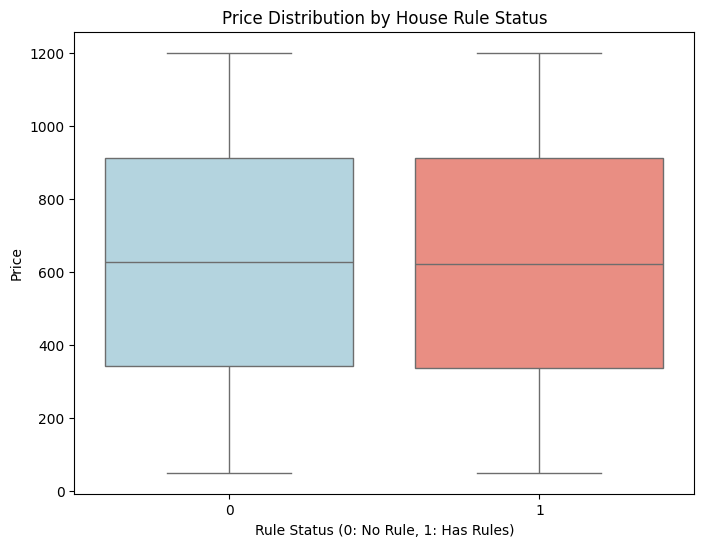

In [ ]:
# Box Plot

palette_colors = {0: "lightblue", 1: "salmon"}

plt.figure(figsize=(8, 6))

sns.boxplot(x='Rule_Status', y='price', data=df_airbnb, hue='Rule_Status', palette=palette_colors, dodge=False)
plt.title('Price Distribution by House Rule Status')
plt.xlabel('Rule Status (0: No Rule, 1: Has Rules)')
plt.ylabel('Price')

plt.legend([],[], frameon=False)

sns.set_style("whitegrid")

plt.show()

From this visualization, we can observe that the median prices are quite similar for both categories, although there is a wide range of prices within each. The similar box sizes suggest that the variability in prices is roughly the same whether house rules are specified or not. This implies that the presence of house rules does not significantly affect the price range for listings in our dataset.


We investigated the average pricing of properties in relation to their house rule status. By grouping properties into those without rules and those with rules, we calculated the average price for each category. The resulting bar graph provides a direct comparison, highlighting whether the average price is significantly different between the two groups.

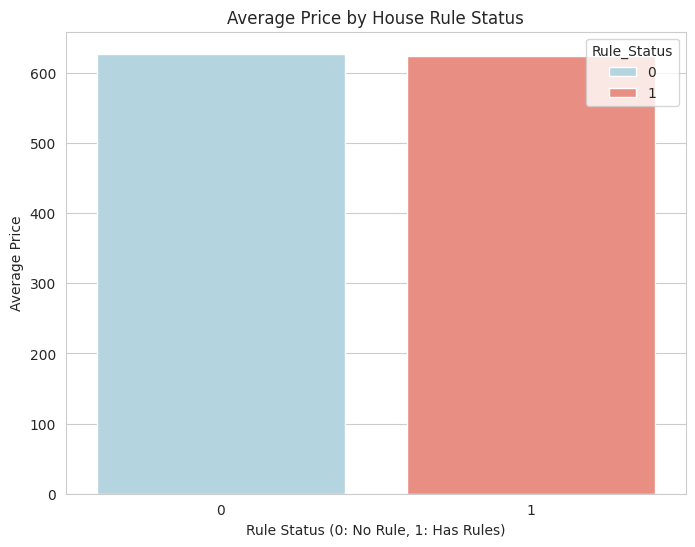

In [ ]:
palette_colors = ["lightblue", "salmon"]

# Calculate average prices
average_prices = df_airbnb.groupby('Rule_Status')['price'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='Rule_Status', y='price', data=average_prices, hue='Rule_Status', palette=palette_colors, dodge=False)
plt.title('Average Price by House Rule Status')
plt.xlabel('Rule Status (0: No Rule, 1: Has Rules)')
plt.ylabel('Average Price')
plt.show()

The bar graph illustrates the average price of Airbnb listings differentiated by their house rule status. The lighter blue bar represents properties with 'No Rule' (0), while the salmon-colored bar represents properties that have specified house rules (1). From the graph, there is no significant difference between properties with house rules and proerties without in regard to their average price.

To expand our NLP efforts after tokenizing the 'house_rules', we conducted sentiment analysis using TextBlob to examine the potential influence of sentiment in 'house_rules' on property prices. We assigned a neutral sentiment score of 0.0 to all entries labeled "no rule", ensuring a consistent baseline for comparison.

In [ ]:
# Create 'house_rules_sentiment' column and get sentiment score for 'house_rules'.  All rows with "no rule" should have score of 0.0
df_airbnb['house_rules_sentiment'] = df_airbnb['house_rules'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
df_airbnb.head(2)

,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,instant_bookable,cancellation_policy,room_type,construction_year,price,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,house_rules,Rule_Status,house_rules_sentiment
0,1001254,Clean & quiet apt home by the park,80014485718,0,Madaline,Brooklyn,Kensington,40.64749,-73.97237,0,strict,Private room,2020,966,193,10,9,1,0,4,6,286,Clean up and treat the home the way you'd like...,1,0.366667
1,1002102,Skylit Midtown Castle,52335172823,1,Jenna,Manhattan,Midtown,40.75362,-73.98377,0,moderate,Entire home/apt,2007,142,28,30,45,1,0,4,2,228,Pet friendly but please confirm with me if the...,1,0.206818


We looked to see if there was any correlation between the properties' (who had additional rules) house_rules_sentiment versus price.  

In [ ]:
rules_sentiment = df_airbnb[df_airbnb['house_rules'].str.lower() != 'no rule']

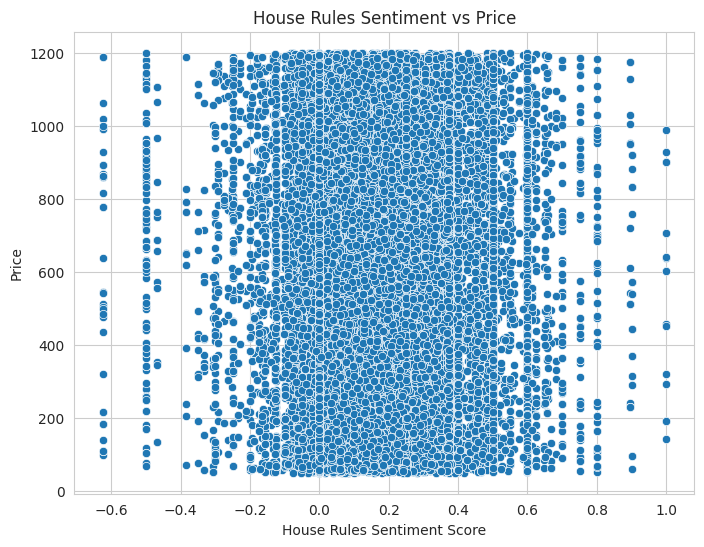

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rules_sentiment, x='house_rules_sentiment', y='price')
plt.title('House Rules Sentiment vs Price')
plt.xlabel('House Rules Sentiment Score')
plt.ylabel('Price')
plt.show()

Finally, we counted all the words under house_rules to see if there was a correlation with price.

In [ ]:
# Create 'house_rules_word_count' and get word count of 'house_rules'.  All rows with "no rule" will reflect as "0" for its word count
df_airbnb['house_rules_word_count'] = df_airbnb['house_rules'].apply(lambda x: 0 if x.lower() == "no rule" else len(x.split()))

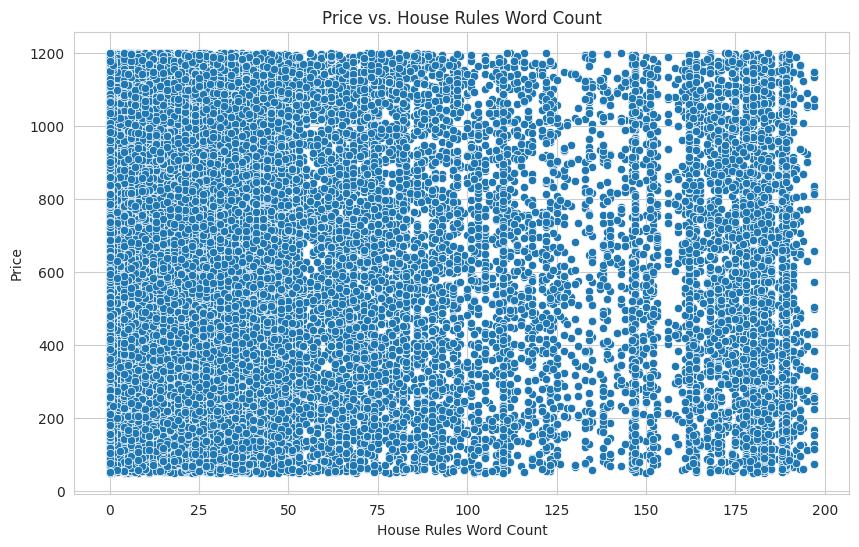

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_airbnb, x='house_rules_word_count', y='price')
plt.title('Price vs. House Rules Word Count')
plt.xlabel('House Rules Word Count')
plt.ylabel('Price')
plt.show()


**Ultimately, there were no significant findings in regard to house_rules versus property prices.**



## **2.4 Correlation of Feature Variables**

Including a correlation matrix into our analysis serves several key purposes. It allows us to identify potential relationships between features, which is crucial for effective feature selection and engineering. By revealing insights into the dataset's structure, the matrix informs our modeling decisions and helps prevent issues like multicollinearity.

In [ ]:
# Filter DataFrame to include only numeric features
numeric_df = df_airbnb.select_dtypes(include=['number'])
numeric_df = numeric_df.sort_index(axis=1)
numeric_df.columns


Index(['Rule_Status', 'availability_365', 'calculated_host_listings_count',
       'construction_year', 'host_identity_verified', 'house_rules_sentiment',
       'house_rules_word_count', 'instant_bookable', 'last_review', 'lat',
       'long', 'minimum_nights', 'number_of_reviews', 'price',
       'review_rate_number', 'reviews_per_month', 'service_fee'],
      dtype='object')

In [ ]:
# Filter DataFrame to include only text features
text_df = df_airbnb.select_dtypes(exclude=['number'])
text_df = text_df.sort_index(axis=1)
text_df.columns

Index(['cancellation_policy', 'host_id', 'host_name', 'house_rules', 'id',
       'name', 'neighbourhood', 'neighbourhood_group', 'room_type'],
      dtype='object')

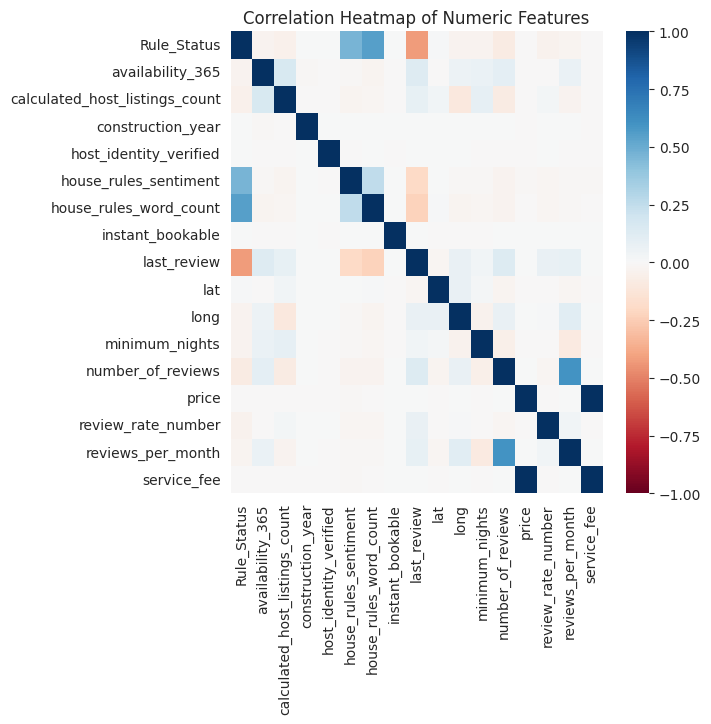

In [ ]:
# Create a correlation matrix using numerics_df and call it corr_mat
corr_mat = numeric_df.corr()
# Using the correlation matrix, generate a correlation heatmap
fig, ax = plt.subplots(figsize = (6, 6))
# Define the date format
sns.heatmap(corr_mat,\
            vmin=-1,
            vmax=1,
            cmap='RdBu',
            ax=ax)
ax.set_title('Correlation Heatmap of Numeric Features');

**Here we quickly noticed that the service fee is a percentage of the price. Therefore, we needed to exclude the service fee from the training model**.

# **Part 3: Feature Engineering**

In this section, we aimed to create additional features for our regression models.  Knowing that our dataset lacks information about bedrooms and beds, we sought ways to add these features to our data.

In [ ]:
df_airbnb.head()

,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,instant_bookable,cancellation_policy,room_type,construction_year,price,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,house_rules,Rule_Status,house_rules_sentiment,house_rules_word_count
0,1001254,Clean & quiet apt home by the park,80014485718,0,Madaline,Brooklyn,Kensington,40.64749,-73.97237,0,strict,Private room,2020,966,193,10,9,1,0,4,6,286,Clean up and treat the home the way you'd like...,1,0.366667,17
1,1002102,Skylit Midtown Castle,52335172823,1,Jenna,Manhattan,Midtown,40.75362,-73.98377,0,moderate,Entire home/apt,2007,142,28,30,45,1,0,4,2,228,Pet friendly but please confirm with me if the...,1,0.206818,75
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,1,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,0,moderate,Entire home/apt,2009,204,41,10,9,0,0,3,1,289,"Please no smoking in the house, porch or on th...",1,0.100000,29
5,1004098,Large Cozy 1 BR Apartment In Midtown East,45498551794,1,Michelle,Manhattan,Murray Hill,40.74767,-73.97500,1,flexible,Entire home/apt,2013,577,115,3,74,0,0,3,1,374,"No smoking, please, and no drugs.",1,0.000000,6
7,1005202,BlissArtsSpace!,90821839709,0,Emma,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,0,moderate,Private room,2009,1060,212,45,49,0,0,5,1,219,House Guidelines for our BnB We are delighted ...,1,0.475000,191


## **3.1 One Hot Encoding**

We one hot encoded cancellation_policy and room_type to be fed into our regression models.

In [ ]:
# Perform one-hot encoding for 'cancellation_policy' and 'room_type' columns
df_airbnb = pd.get_dummies(df_airbnb, columns=['cancellation_policy', 'room_type'], dtype=int)

In [ ]:
# Clean up column names again because we added dummy columns such as "room_type_Entire home/apt"
df_airbnb.columns = (df_airbnb.columns
                      .str.replace(' ', '_', regex=True)
                      .str.replace('/', '_', regex=True)
                      .str.lower()
                    )
df_airbnb.columns

Index(['id', 'name', 'host_id', 'host_identity_verified', 'host_name',
       'neighbourhood_group', 'neighbourhood', 'lat', 'long',
       'instant_bookable', 'construction_year', 'price', 'service_fee',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'review_rate_number',
       'calculated_host_listings_count', 'availability_365', 'house_rules',
       'rule_status', 'house_rules_sentiment', 'house_rules_word_count',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict', 'room_type_entire_home_apt',
       'room_type_hotel_room', 'room_type_private_room',
       'room_type_shared_room'],
      dtype='object')

## **3.2 Bedroom Count**

Due to the lack of information about room numbers for each property, we looked to enhance the tokenizing of our process_text function and applied it to our 'name' column.  The aim was to parse bedroom counts for the properties that specified the number of bedrooms in their names, then imputing the average for all the null values.

In [ ]:
df_airbnb['parsed_name'] = df_airbnb['name'].apply(process_text)

We counted the most common words to help us identify key terms such as 'br', 'studio', '4br' to enhance our process_text fuction as well as create a label_bedrooms function.

In [ ]:
# Create a Counter to find the most common words
all_name_words = [word for sublist in df_airbnb['parsed_name'] for word in sublist]
word_counts = Counter(all_name_words)

# Get the top x most common words and convert the list of tuples [(name_word, count)] to a list of words only
x = 50
most_common_name_words = word_counts.most_common(x)
print(most_common_name_words)

[('room', 21031), ('bedroom', 17150), ('private', 15562), ('apartment', 13732), ('1', 13178), ('2', 11576), ('cozy', 10401), ('apt', 9318), ('studio', 8659), ('brooklyn', 8558), ('br', 7695), ('spacious', 7451), ('manhattan', 7229), ('park', 6377), ('east', 5849), ('sunny', 5583), ('williamsburg', 5282), ('beautiful', 5065), ('near', 4950), ('bed', 4778), ('nyc', 4667), ('w', 4636), ('village', 4298), ('heart', 4243), ('home', 4051), ('loft', 4025), ('3', 4023), ('large', 4005), ('modern', 3836), ('central', 3616), ('luxury', 3427), ('location', 3390), ('bright', 3372), ('new', 3333), ('west', 3069), ('bushwick', 2808), ('one', 2755), ('charming', 2749), ('min', 2705), ('side', 2687), ('midtown', 2661), ('upper', 2535), ('quiet', 2527), ('brownstone', 2465), ('bath', 2457), ('clean', 2381), ('great', 2338), ('close', 2280), ('harlem', 2267), ('square', 2146)]


This helper function is not 100% accurate, since some properties such as "3-story 2 BR" gets categorized as 3 bedroom.

In [ ]:
def label_bedrooms(parsed_name):

    # Check for specific keywords or numbers and return corresponding bedroom counts
    if 'studio' in parsed_name or '1' in parsed_name:
        return 1
    elif '2' in parsed_name:
        return 2
    elif '3' in parsed_name:
        return 3
    elif '4' in parsed_name:
        return 4
    else:
        return None

In [ ]:
df_airbnb['bedroom_count'] = df_airbnb['parsed_name'].apply(label_bedrooms)
df_airbnb['bedroom_count']

0         NaN
1         NaN
4         1.0
5         1.0
7         NaN
         ... 
102029    2.0
102030    NaN
102031    NaN
102032    2.0
102040    NaN
Name: bedroom_count, Length: 98509, dtype: float64

In [ ]:
# Imputed missing 'bedroom_count' values with the mean
mean_bedroom_count = df_airbnb['bedroom_count'].mean()
df_airbnb['bedroom_count'].fillna(mean_bedroom_count, inplace=True)
df_airbnb['bedroom_count']

0         1.518108
1         1.518108
4         1.000000
5         1.000000
7         1.518108
            ...   
102029    2.000000
102030    1.518108
102031    1.518108
102032    2.000000
102040    1.518108
Name: bedroom_count, Length: 98509, dtype: float64

In [ ]:
df_airbnb['bedroom_count'].describe()

count    98509.000000
mean         1.518108
std          0.447765
min          1.000000
25%          1.518108
50%          1.518108
75%          1.518108
max          4.000000
Name: bedroom_count, dtype: float64

----------------

# Part 4: Machine Learning Modeling

Initially, our focus was on predicting nightly prices for Airbnb listings to aid investors in optimizing revenue streams. However, our geospatial analysis uncovered a significant correlation: higher review rates per month were linked to proximity to airports. This led us to rethink our approach.

Inspired by this insight, we refined our modeling strategy. Instead of solely predicting nightly prices, we introduced a new combined target variable: the product of nightly price and average reviews per month. This shift provides a more comprehensive view of revenue potential by considering both pricing and booking frequency.

By integrating pricing and booking frequency targets into our predictive model, as well as engineered input features from our raw dataset, we offer investors insights into listing value and popularity.

## 4.1 Preprocessing: Create Features and Label and Split Data into Train and Test

In [ ]:
numeric_df = df_airbnb.select_dtypes(include=['number'])
numeric_df = numeric_df.sort_index(axis=1)
numeric_df.columns

Index(['availability_365', 'bedroom_count', 'calculated_host_listings_count',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict', 'construction_year',
       'host_identity_verified', 'house_rules_sentiment',
       'house_rules_word_count', 'instant_bookable', 'last_review', 'lat',
       'long', 'minimum_nights', 'number_of_reviews', 'price',
       'review_rate_number', 'reviews_per_month', 'room_type_entire_home_apt',
       'room_type_hotel_room', 'room_type_private_room',
       'room_type_shared_room', 'rule_status', 'service_fee'],
      dtype='object')

We dropped 'construction-year' because the age of a property was not calculated to be included into our model.

In [ ]:
# Store the  target variable into "target"
target = numeric_df['price']*numeric_df["reviews_per_month"]

# Store numeric features dataframe into variable called "features
features = numeric_df.drop(['construction_year', 'price', 'service_fee','reviews_per_month'], axis=1)

In [ ]:
# assign appropriate value to seed and conduct 80/20 train-test split with random_state = seed
seed = 42

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((78807, 21), (19702, 21), (78807,), (19702,))

## 4.2 PCA to Reduce Dimensionality

By reducing multicollinearity, PCA enhances the stability of regularized regression models.

In [ ]:
# Intermediate step to address fact that PCA is not scale invariant
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

scaler = StandardScaler()

# Standardizing the features based on unit variance
X_train_normalized = scaler.fit_transform(X_train)

# Instantiate and Fit PCA
pca = PCA(n_components=len(X_train.columns))
pca.fit(X_train_normalized)

# Save the explained variance ratios into variable called "explained_variance_ratios"
explained_variance_ratios = pca.explained_variance_ratio_

# Save the CUMULATIVE explained variance ratios into variable called "cum_evr"
cum_evr = np.cumsum(pca.explained_variance_ratio_)

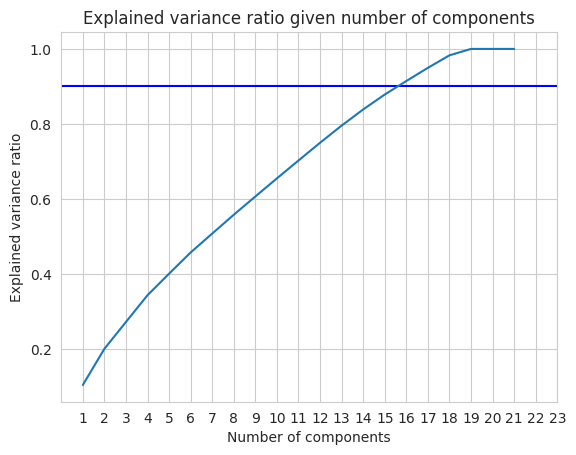

In [ ]:
# find optimal num components to use (n) by plotting explained variance ratio
fig, ax = plt.subplots()
ax.axhline(y=0.9, color='b', linestyle='-')
ax.plot(cum_evr)
ax.set_title('Explained variance ratio given number of components')
ax.set_xlabel('Number of components')
ax.set_ylabel('Explained variance ratio')
ax.set_xticks([x for x in range(0,23)])
ax.set_xticklabels(labels = [x for x in range(1,24)], rotation=0)
plt.show()

In [ ]:
# Refit and transform on training with parameter n (as deduced from the last step)
pca = PCA(n_components=18)
X_train_pca = pca.fit_transform(X_train_normalized)

# Transform on Testing Set and store it as `X_test_pca`
X_test_normalized = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_normalized)

## 4.3 Regression Models

### (a) Linear Regression with PCA (Unregularized)

We utilized PCAed training data to mitigate potential multicollinearity.

In [ ]:
# Import required libraries
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import r2_score

# Initialize model with default parameters and fit it on the training set
reg = LinearRegression()
reg.fit(X_train_pca, y_train)

# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = reg.predict(X_test_pca)

# Find the R-squared score and store the value in `lin_reg_score`
lin_reg_score = r2_score(y_test,y_pred)
lin_reg_score

0.2747567263664369

### (b) Ridge Regression (L2 Regularized)

We utilized PCA-transformed training data, as regularized regression models are not scale-invariant.

In [ ]:
# Import required libraries
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for alpha values to tune
param_grid = {'alpha': [0.1, 1, 10, 100]}

# Initialize Ridge model
reg_ridge = Ridge()

# Initialize GridSearchCV with the Ridge model and parameter grid
grid_search = GridSearchCV(estimator=reg_ridge, param_grid=param_grid, cv=5)

# Fit the GridSearchCV on the training data
grid_search.fit(X_train_pca, y_train)

# Get the best model found by GridSearchCV
best_ridge = grid_search.best_estimator_

# Use the best model to predict on the test pca set
y_pred = best_ridge.predict(X_test_pca)

# Find the r2 score and store the value in `ridge_score`
ridge_score = r2_score(y_test,y_pred)
ridge_score

0.2748123709474217

### (c) Elastic Net Regression (L1 + L2 Regularized)

In [ ]:
# Define the parameter grid for alpha and l1_ratio values to tune
param_grid = {'alpha': [0.1, 1, 10, 100],
              'l1_ratio': [0.1, 0.5, 0.9]}

# Initialize model
elastic_net = ElasticNet()

# Initialize GridSearchCV with the ElasticNet model and parameter grid
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train_pca, y_train)

# Get the best model found by GridSearchCV
best_elastic_net = grid_search.best_estimator_

# Use the best model to predict on the test set
y_pred = best_elastic_net.predict(X_test_pca)

# Calculate the r2 score
en_score = r2_score(y_test, y_pred)
en_score

0.2761427948644416

### (d) Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# prep for parameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
    }
# Initialize model
random_forest = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with the RandomForestRegressor model and parameter grid
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Get the best model found by GridSearchCV
best_random_forest = grid_search.best_estimator_

# Use the best model to predict on the test set
y_pred = best_random_forest.predict(X_test)

# Calculate the R-squared score
rfr_score = r2_score(y_test, y_pred)
rfr_score

0.6212069949251271

# Part 5: Challenges/Potential Next Steps/Future Direction

To conclude our analysis, we have witnessed a notable improvement in the performance of our predictive models following a critical revision of our target variable. Initially, our models struggled to achieve accuracy, with predictions hovering around a mere 2% when solely predicting nightly rates (price). However, with the introduction of our new combined target variable— multiplying price by reviews_per_month— we observed a significant enhancement in predictive accuracy.

Linear Regression, Ridge Regression, and Elastic Net all experienced substantial performance gains, with accuracy levels rising to 27%. While this improvement is notable compared to the initial 2%, it falls short of our ideal accuracy. Notably, our Random Forest Regression (RFR) model demonstrated exceptional improvement, with accuracy soaring from 30% to 62%.

Given the substantial improvement in performance and the superior accuracy achieved by RFR, we have identified it as the most promising model for future iterations of our predictive modeling efforts. While our ultimate goal may be an accuracy of 80%, RFR has proven to be the most effective approach thus far.

Moving forward, we will prioritize the continued refinement and enhancement of our Random Forest Regression model, leveraging further feature engineering, exploring additional data sources, and optimizing model parameters. Additionally, integrating external datasets such as real estate market trends from Zillow or demographic data holds promise for further improving predictive accuracy.

Moreover, as data volume and model complexity increase, enhancing computational efficiency through techniques like parallel processing or cloud-based computation will be crucial.

In conclusion, by addressing these challenges comprehensively and leveraging advanced modeling techniques and technologies, we will be poised to significantly enhance the predictive accuracy of our models. Our concerted effort will provide reliable pricing strategies for Airbnb investors, ensuring that our future models are not only more accurate but also more robust and capable of handling diverse and complex real-world scenarios.